# **HSBC Hackathon Submission - By Hrithik  Reddy**
## **Problem Statment** - Develop an AI model capable of detecting fraudulent transactions in real-time. Use historical transaction data to train the model to identify anomalies and flag suspicious activities.

# Model Documentation - Weighted Classification using Two XGBoost Models

This documentation provides an overview of the weighted classification approach using two XGBoost models. The models are trained with different hyperparameters, and their predictions are combined using a weighted average.

## Model Parameters

### Model 1 Parameters:
- **colsample_bytree**: `0.8`
- **learning_rate**: `0.01`
- **max_depth**: `9`
- **n_estimators**: `100`
- **subsample**: `0.8`

### Model 2 Parameters:
- **colsample_bytree**: `1.0`
- **learning_rate**: `0.2`
- **max_depth**: `6`
- **n_estimators**: `100`
- **subsample**: `1.0`

## Weightage for Model Predictions

The predictions from the two models are combined using a weighted average, with the following weights:

- **Model 1 Weight**: `0.6`
- **Model 2 Weight**: `0.4`

## Prediction Process

1. **Training**: Both models are trained separately using their respective parameters on the same dataset.

2. **Prediction**:
   - Each model generates probabilities for the positive class (e.g., fraud) on the test dataset.
   - The probabilities are combined using a weighted average:
   
   **Combined Probability** = (0.6 × Model 1 Probability) + (0.4 × Model 2 Probability)


3. **Thresholding**:
   - The combined probabilities are then thresholded at `0.5` to make the final binary classification:
     \[
     \text{Final Prediction} = 
     \begin{cases} 
     1 & \text{if Combined Probability} \geq 0.5 \\
     0 & \text{otherwise}
     \end{cases}
     \]

## Evaluation Metrics

The performance of the combined model can be evaluated using various metrics such as:

- **Precision**: The proportion of positive identifications that are actually correct.
- **Recall**: The proportion of actual positives that are correctly identified.
- **F1-Score**: The harmonic mean of precision and recall.
- **ROC AUC Score**: The Area Under the Receiver Operating Characteristic Curve, indicating the model's ability to distinguish between the classes.

## Conclusion

This approach allows leveraging the strengths of two models with different configurations by combining their predictions in a weighted manner. The choice of weights (0.6 for Model 1 and 0.4 for Model 2) reflects the relative importance or performance of each model in the final decision-making process.


In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
from matplotlib import  pyplot as plt 


## 1.Data Exploration and EDA

In [2]:
data = pd.read_csv("train_hsbc_df.csv")
data.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C583110837','3','M','28007','M480139044','28007','es_health',44.26,1
1,0,'C1332295774','3','M','28007','M480139044','28007','es_health',324.50,1
2,0,'C1160421902','3','M','28007','M857378720','28007','es_hotelservices',176.32,1
3,0,'C966214713','3','M','28007','M857378720','28007','es_hotelservices',337.41,1
4,0,'C1450140987','4','F','28007','M1198415165','28007','es_wellnessandbeauty',220.11,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513643 entries, 0 to 513642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         513643 non-null  int64  
 1   customer     513643 non-null  object 
 2   age          513643 non-null  object 
 3   gender       513643 non-null  object 
 4   zipcodeOri   513643 non-null  object 
 5   merchant     513643 non-null  object 
 6   zipMerchant  513643 non-null  object 
 7   category     513643 non-null  object 
 8   amount       513643 non-null  float64
 9   fraud        513643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 39.2+ MB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
step,513643.0,94.992629,51.063474,0.0,52.00,97.00,139.00,179.00
amount,513643.0,37.915481,111.557455,0.0,13.74,26.92,42.55,7665.56
fraud,513643.0,0.012071,0.109201,0.0,0.00,0.00,0.00,1.00


In [5]:

def unique_percentage(df):
    object_columns = df.select_dtypes(include=['object']).columns
    results = {}
    
    for col in object_columns:
        total_values = df[col].count()
        unique_values = df[col].nunique()
        percentage = (unique_values / total_values) * 100
        results[col] = f"{percentage:.2f}%"
    
    return results
unique_percentage(data)

{'customer': '0.80%',
 'age': '0.00%',
 'gender': '0.00%',
 'zipcodeOri': '0.00%',
 'merchant': '0.01%',
 'zipMerchant': '0.00%',
 'category': '0.00%'}

In [6]:
df = data.copy()

In [7]:
# Fraud distribution
fraud_dist = df['fraud'].value_counts(normalize=True) * 100
print("\nFraud distribution:")
print(fraud_dist)


Fraud distribution:
fraud
0    98.792936
1     1.207064
Name: proportion, dtype: float64


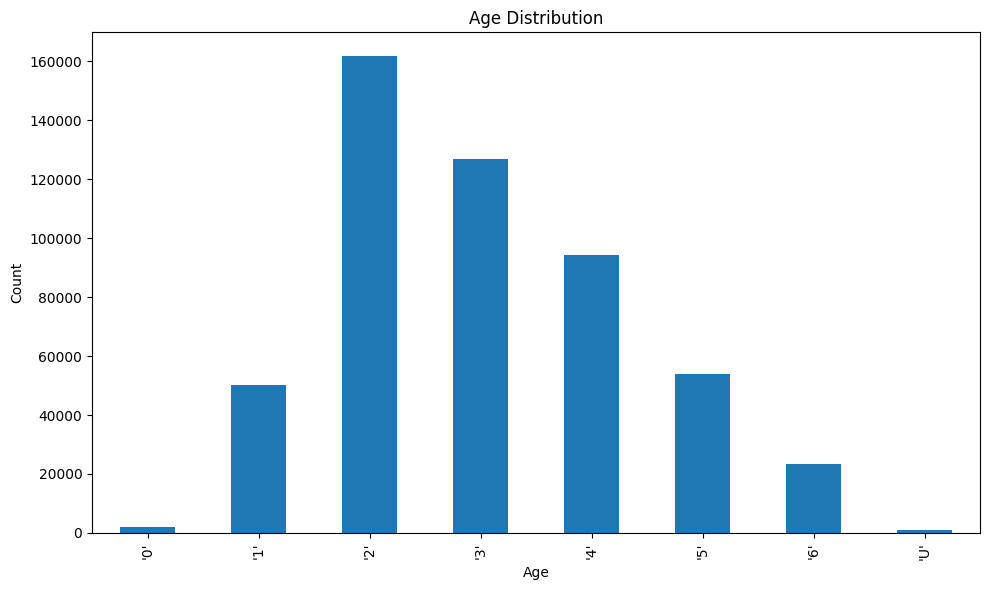

In [8]:
# Age distribution
plt.figure(figsize=(10, 6))
df['age'].value_counts().sort_index().plot(kind='bar')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
# plt.savefig('age_distribution.png')
# plt.close()

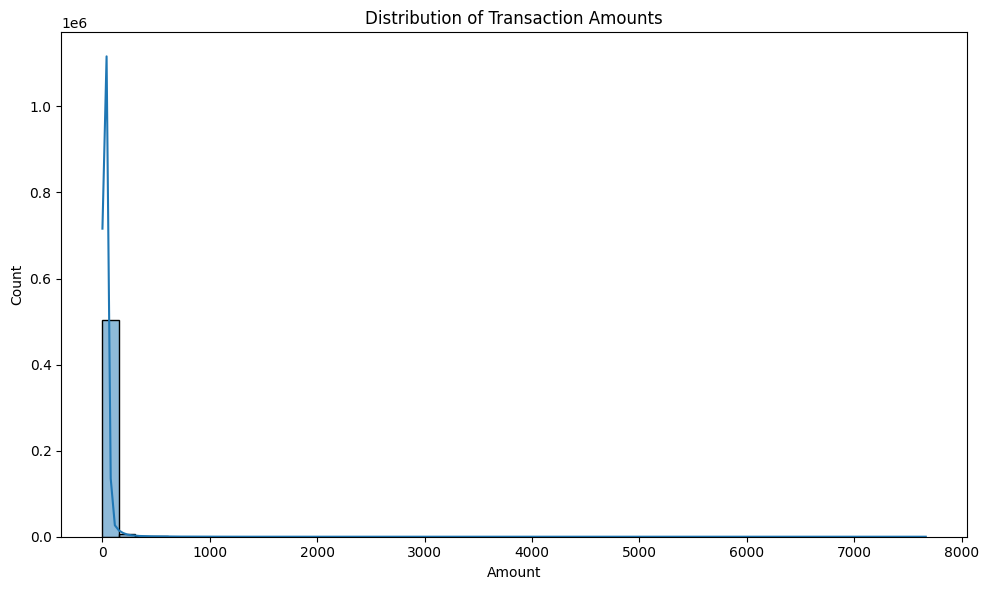

In [9]:
# Amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.tight_layout()
# plt.savefig('amount_distribution.png')
# plt.close()


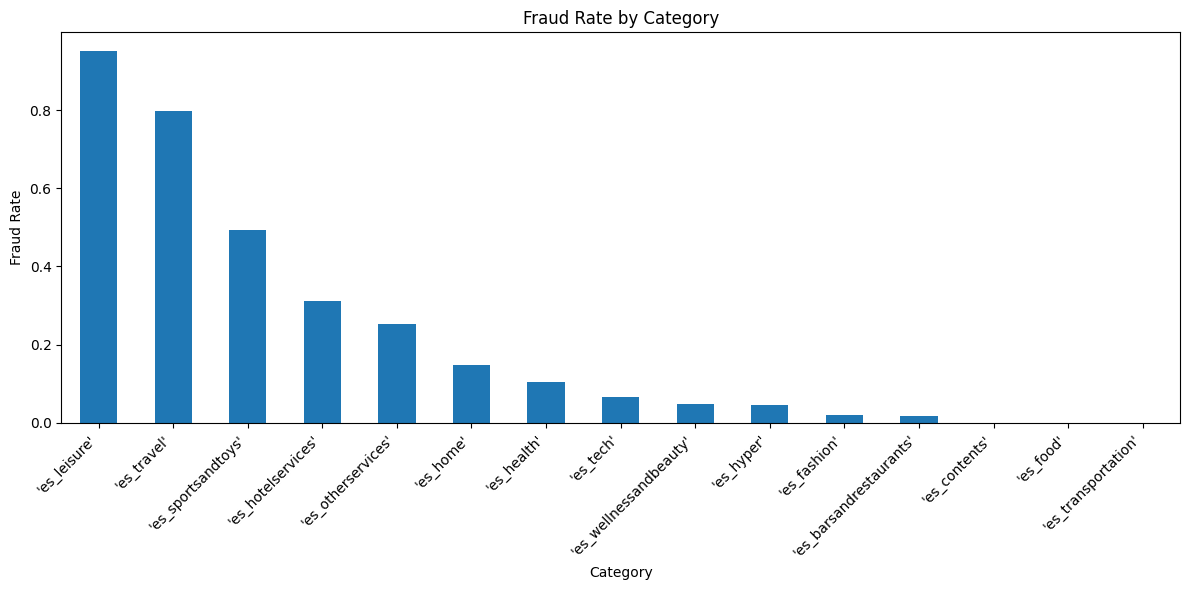

In [10]:
# Fraud by category
fraud_by_category = df.groupby('category')['fraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
fraud_by_category.plot(kind='bar')
plt.title('Fraud Rate by Category')
plt.xlabel('Category')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# plt.savefig('fraud_by_category.png')
# plt.close()

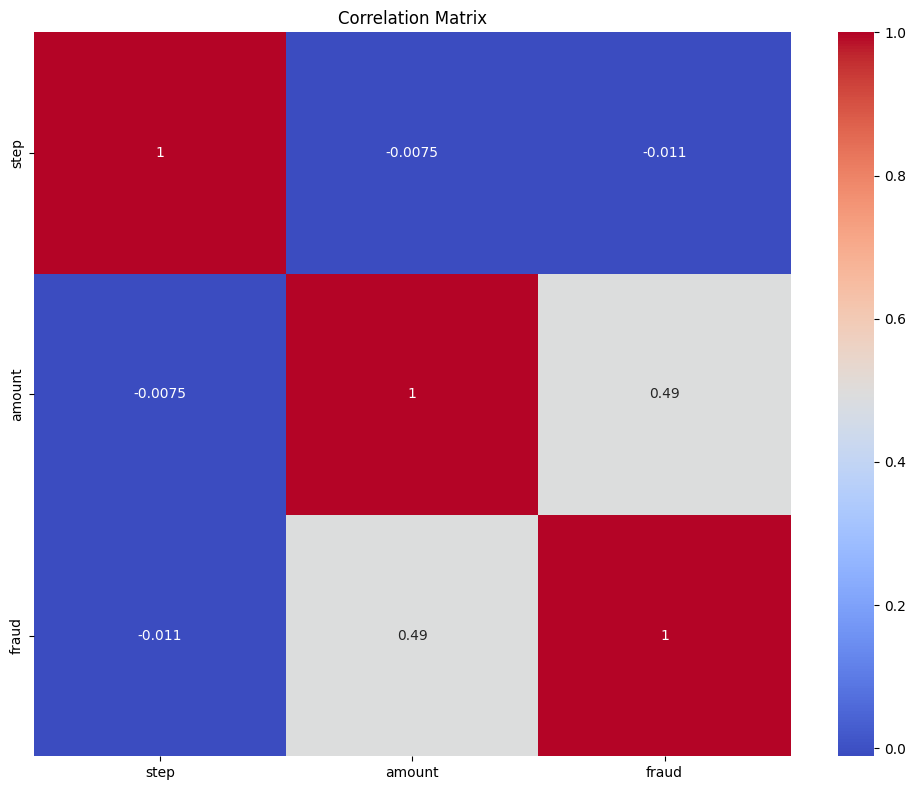

In [11]:
# Correlation matrix for numerical columns
corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
# plt.savefig('correlation_matrix.png')
# plt.close()

In [12]:
data

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C583110837','3','M','28007','M480139044','28007','es_health',44.26,1
1,0,'C1332295774','3','M','28007','M480139044','28007','es_health',324.50,1
2,0,'C1160421902','3','M','28007','M857378720','28007','es_hotelservices',176.32,1
3,0,'C966214713','3','M','28007','M857378720','28007','es_hotelservices',337.41,1
4,0,'C1450140987','4','F','28007','M1198415165','28007','es_wellnessandbeauty',220.11,1
...,...,...,...,...,...,...,...,...,...,...
513638,179,'C748358246','2','M','28007','M1823072687','28007','es_transportation',51.17,0
513639,179,'C1753498738','3','F','28007','M1823072687','28007','es_transportation',20.53,0
513640,179,'C650108285','4','F','28007','M1823072687','28007','es_transportation',50.73,0
513641,179,'C123623130','2','F','28007','M349281107','28007','es_fashion',22.44,0


In [13]:
data = data.drop("zipMerchant" , axis =1 )

In [14]:
data = data.drop("zipcodeOri" , axis =1 )

In [15]:
data = data.drop("customer" , axis =1 )

In [16]:
print(data.shape)

(513643, 7)


## 2.Feature Engineering 

In [17]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder


ordinal_columns = ['age', 'gender']
ordinal_encoder = OrdinalEncoder()
data[ordinal_columns] = ordinal_encoder.fit_transform(df[ordinal_columns])

# One-hot encoding for 'merchant' and 'category'
onehot_columns = ['merchant', 'category']
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(data[onehot_columns])

# Get feature names for one-hot encoded columns
feature_names = onehot_encoder.get_feature_names_out(onehot_columns)

# Create a new DataFrame with one-hot encoded features
onehot_data = pd.DataFrame(onehot_encoded, columns=feature_names)

# Combine the original DataFrame with one-hot encoded features
data_encoded = pd.concat([data.drop(columns=onehot_columns), onehot_data], axis=1)

# Print info about the new DataFrame
print(data_encoded.info())

# Optional: If you want to see the mapping for ordinal encoding
for col in ordinal_columns:
    print(f"\nOrdinal encoding mapping for {col}:")
    for category, code in zip(ordinal_encoder.categories_[ordinal_columns.index(col)], range(len(ordinal_encoder.categories_[ordinal_columns.index(col)]))):
        print(f"{category}: {code}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513643 entries, 0 to 513642
Data columns (total 70 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   step                              513643 non-null  int64  
 1   age                               513643 non-null  float64
 2   gender                            513643 non-null  float64
 3   amount                            513643 non-null  float64
 4   fraud                             513643 non-null  int64  
 5   merchant_'M1053599405'            513643 non-null  float64
 6   merchant_'M117188757'             513643 non-null  float64
 7   merchant_'M1198415165'            513643 non-null  float64
 8   merchant_'M1294758098'            513643 non-null  float64
 9   merchant_'M1313686961'            513643 non-null  float64
 10  merchant_'M1352454843'            513643 non-null  float64
 11  merchant_'M1353266412'            513643 non-null  f

In [18]:
X , y = data_encoded.drop("fraud" , axis =1  )  , data_encoded["fraud"]

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513643 entries, 0 to 513642
Data columns (total 69 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   step                              513643 non-null  int64  
 1   age                               513643 non-null  float64
 2   gender                            513643 non-null  float64
 3   amount                            513643 non-null  float64
 4   merchant_'M1053599405'            513643 non-null  float64
 5   merchant_'M117188757'             513643 non-null  float64
 6   merchant_'M1198415165'            513643 non-null  float64
 7   merchant_'M1294758098'            513643 non-null  float64
 8   merchant_'M1313686961'            513643 non-null  float64
 9   merchant_'M1352454843'            513643 non-null  float64
 10  merchant_'M1353266412'            513643 non-null  float64
 11  merchant_'M1400236507'            513643 non-null  f

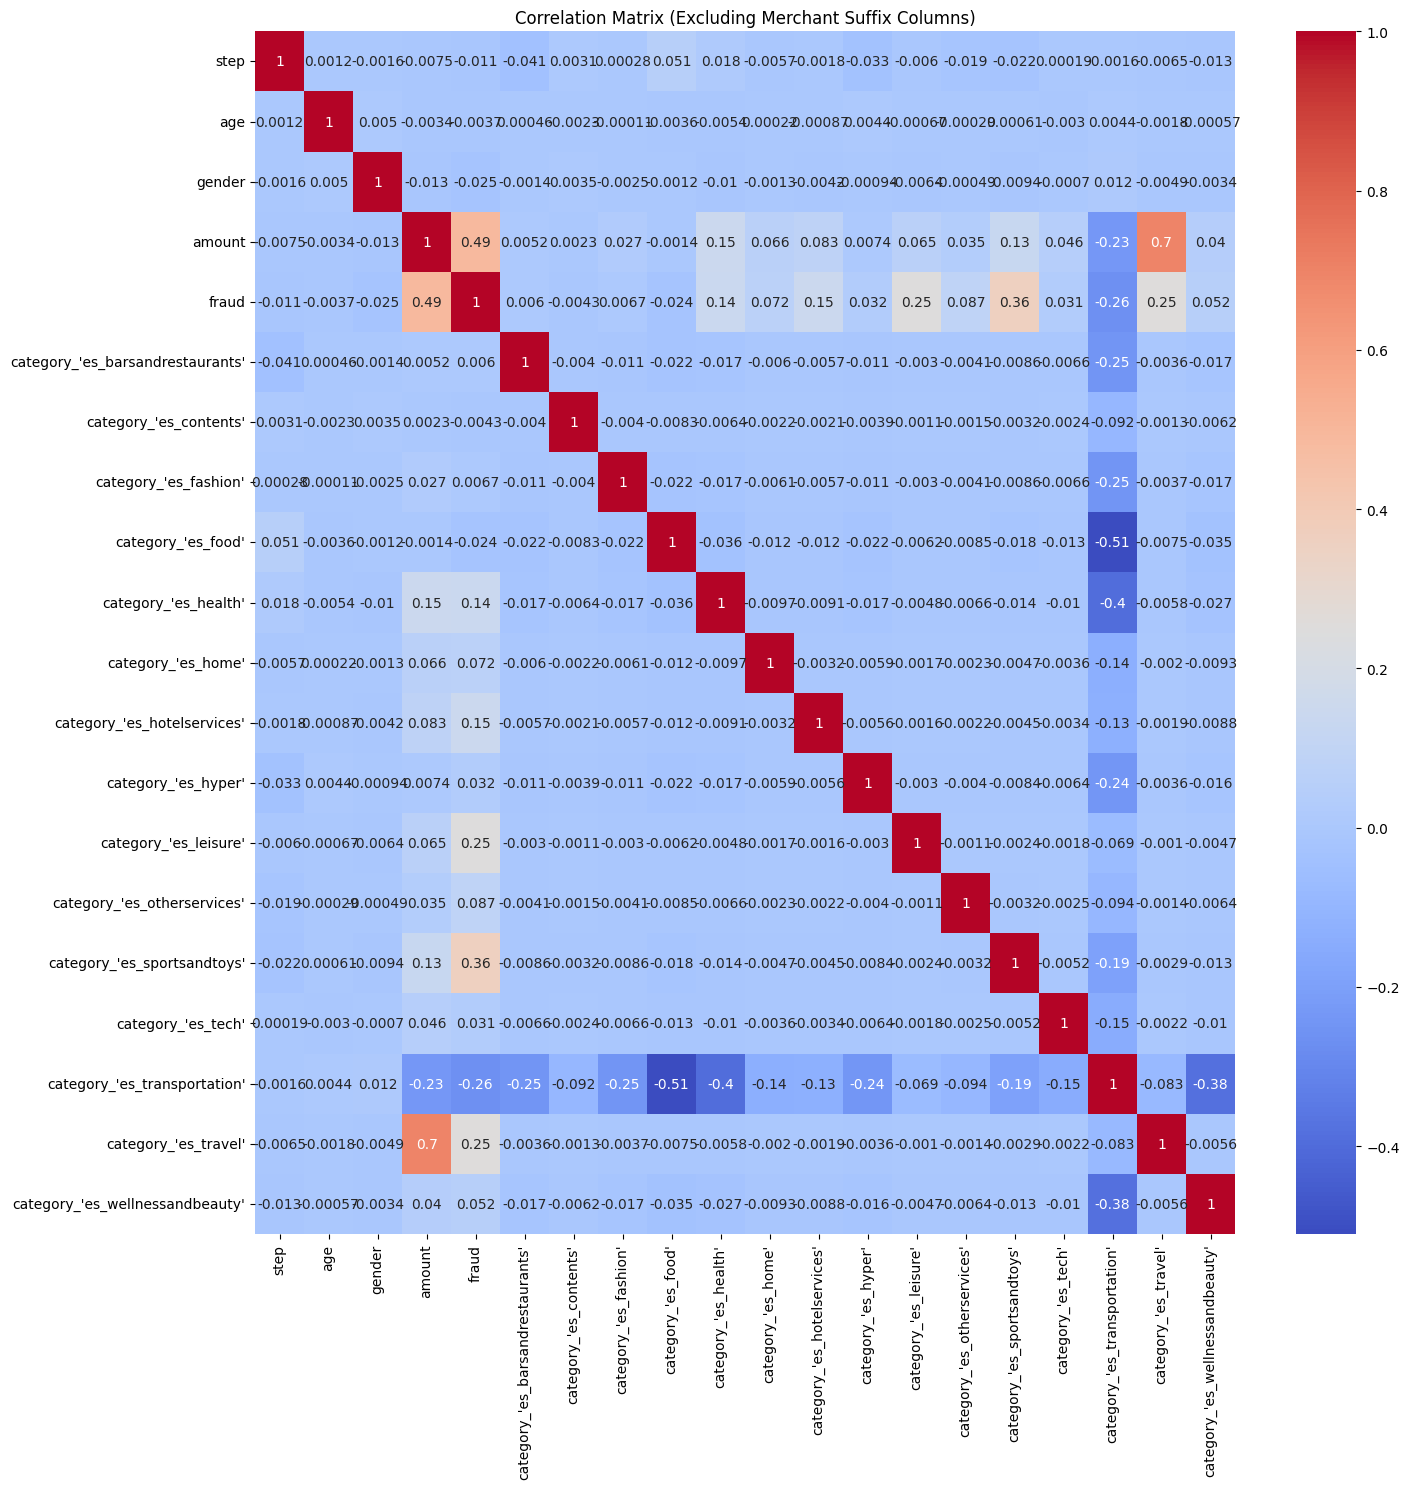

In [20]:
non_merchant_columns = [col for col in data_encoded.select_dtypes(include=['int64', 'float64']).columns if not col.startswith('merchant')]

# Calculate the correlation matrix for the filtered columns
corr_matrix = data_encoded[non_merchant_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Excluding Merchant Suffix Columns)')
plt.tight_layout()
plt.show()

In [21]:
# Qauntiles of Transaction Amount 
print("Transaction Amounts Quantiles:")
print(data['amount'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))


Transaction Amounts Quantiles:
0.010      0.57
0.025      1.39
0.100      5.57
0.250     13.74
0.500     26.92
0.750     42.55
0.900     60.21
0.975    126.89
0.990    236.54
Name: amount, dtype: float64


/home/hrithik2212/HSBC/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


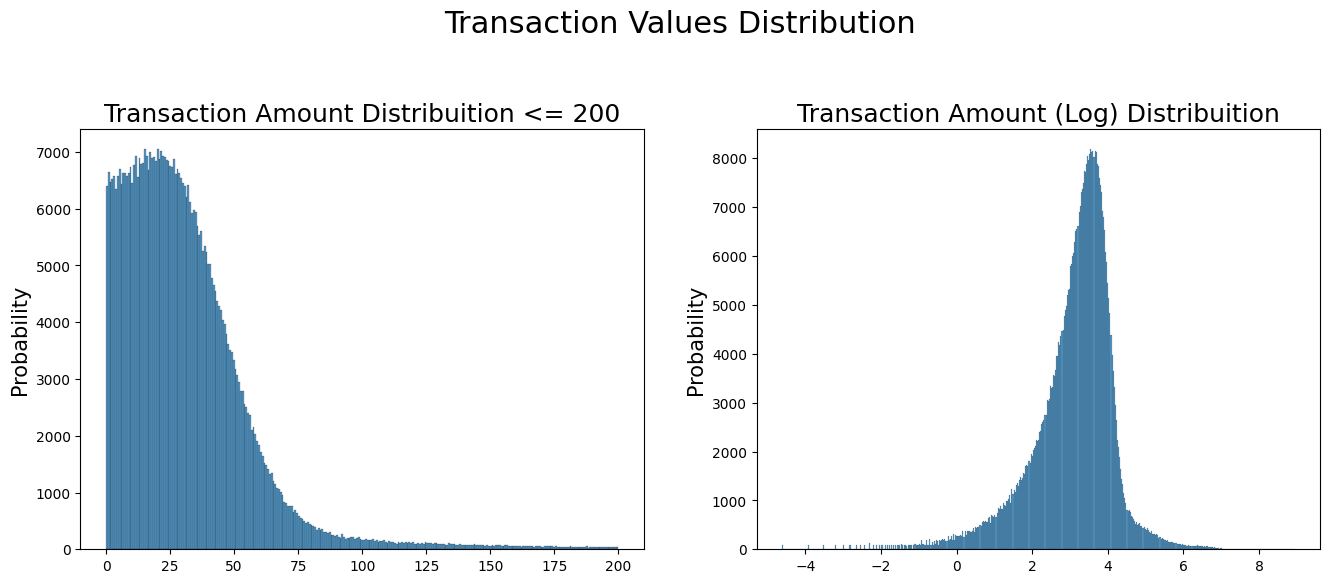

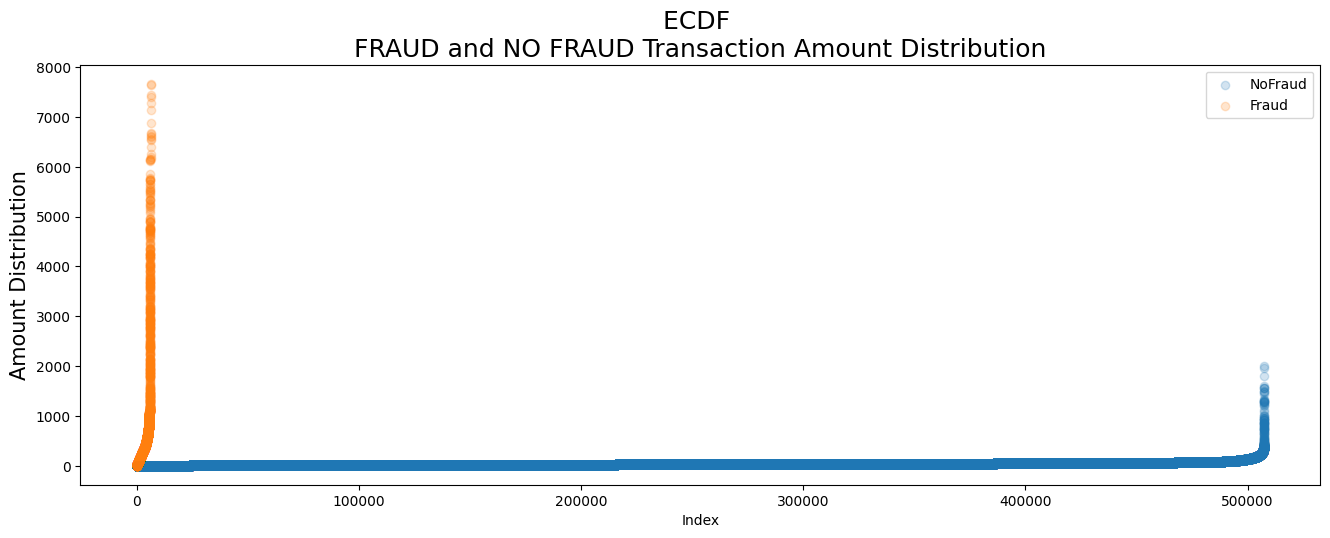

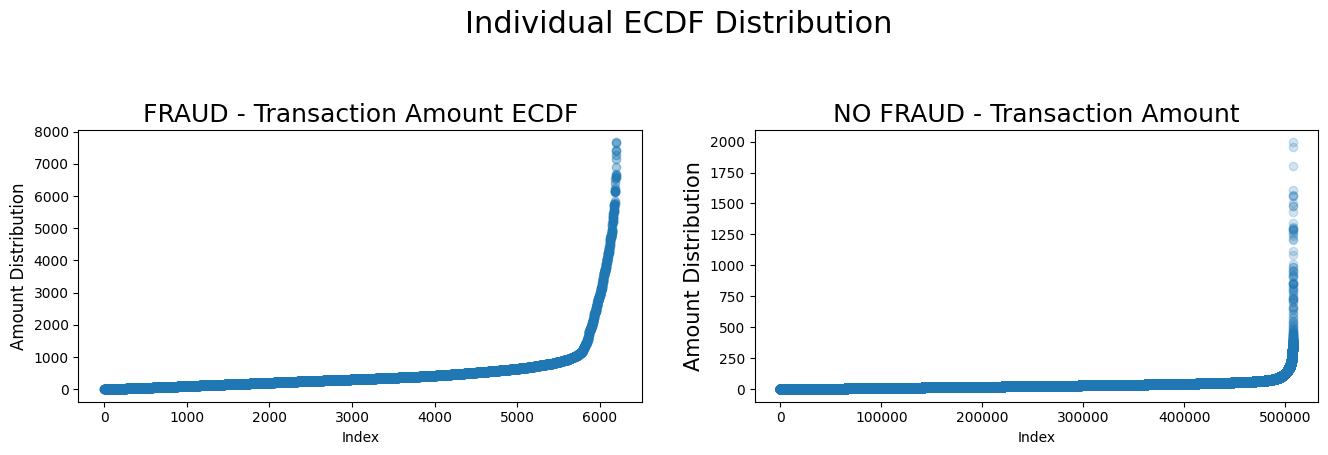

In [22]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
g = sns.histplot(data[data['amount'] <= 200]['amount'])
g.set_title("Transaction Amount Distribuition <= 200", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.histplot(np.log(data['amount']))
g1.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))


plt.subplot(212)
g4 = plt.scatter(range(data[data['fraud'] == 0].shape[0]),
                 np.sort(data[data['fraud'] == 0]['amount'].values), 
                 label='NoFraud', alpha=.2)
g4 = plt.scatter(range(data[data['fraud'] == 1].shape[0]),
                 np.sort(data[data['fraud'] == 1]['amount'].values), 
                 label='Fraud', alpha=.2)
g4= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Amount Distribution", fontsize=15)
g4 = plt.legend()

plt.figure(figsize=(16,12))

plt.subplot(321)
g = plt.scatter(range(data[data['fraud'] == 1].shape[0]), 
                 np.sort(data[data['fraud'] == 1]['amount'].values), 
                label='fraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18) # Empirical Cumulative Distibution Frequency 
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
g1 = plt.scatter(range(data[data['fraud'] == 0].shape[0]),
                 np.sort(data[data['fraud'] == 0]['amount'].values), 
                 label='NoFraud', alpha=.2)
g1= plt.title("NO FRAUD - Transaction Amount", fontsize=18)
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=22)

plt.show()

## 3.Modelling 

* All the model hyperparameter finetunnning was done in Google collab due compute limitations on local and the best hyperparameters were used 
* Code and output of hyperparameter tunning using GridSearchCV is shown in markdown under model headings 

In [23]:
from sklearn.model_selection import train_test_split 
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y , shuffle=True )

# Optional: print the shape of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (410914, 69)
X_test shape: (102729, 69)
y_train shape: (410914,)
y_test shape: (102729,)


### 3.1 Model-1 (XGBoost Tuned towards minimizing false positive)

```python
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import warnings 
warnings.filterwarnings("ignore")
# Initialize the XGBoost classifier with GPU support and verbosity
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss',
    tree_method='gpu_hist',   # Use GPU for training
    predictor='gpu_predictor', # Use GPU for prediction
    verbosity=2,               # Increase verbosity to get more logs
)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='precision', 
                           cv=5,  
                           verbose=1,  # Verbose output during GridSearchCV
                           n_jobs=-1)

# Fit the model using the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_}")

# You can now use the best estimator to predict on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Optional: Evaluate the model on the test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

```

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: 
- `colsample_bytree`: 0.8
- `learning_rate`: 0.01
- `max_depth`: 9
- `n_estimators`: 100
- `subsample`: 0.8

Best Cross-Validation Accuracy: **0.9500870342880395**

|            | precision | recall | f1-score | support |
|------------|------------|--------|----------|---------|
| **0**      | 1.00       | 1.00   | 1.00     | 101,489 |
| **1**      | 0.96       | 0.62   | 0.75     | 1,240   |

|                    |           |        |          |         | 
|--------------------|-----------|--------|----------|---------|
| **accuracy**       |           |        | 1.00     | 102,729 |
| **macro avg**      | 0.98      | 0.81   | 0.88     | 102,729 |
| **weighted avg**   | 0.99      | 1.00   | 0.99     | 102,729 |


In [24]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the XGBoost classifier to use CPU
xgb_model = XGBClassifier(
    n_estimators=100,         # Number of trees
    max_depth=9,              # Maximum depth of each tree
    learning_rate=0.01,        # Learning rate (shrinkage)
    subsample=0.8,            # Subsample ratio of the training instances
    colsample_bytree=0.8,     # Subsample ratio of columns when constructing each tree
    use_label_encoder=False,  # Disable the use of the label encoder
    eval_metric='logloss',    # Evaluation metric
    tree_method='hist',       # Use histogram-based algorithm on CPU
    predictor='cpu_predictor' # Use CPU for prediction
)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


/home/hrithik2212/HSBC/venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:14:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9951425595498836
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    101489
           1       0.96      0.62      0.76      1240

    accuracy                           1.00    102729
   macro avg       0.98      0.81      0.88    102729
weighted avg       1.00      1.00      0.99    102729



In [25]:
from joblib import dump

# Save the model to a file
dump(xgb_model, 'xgb_model_1a.joblib')


['xgb_model_1a.joblib']

### 3.2 Model 2 (XGBoost model tuned towards predicting on actual fradulent data)

```python
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import warnings 
warnings.filterwarnings("ignore")
# Initialize the XGBoost classifier with GPU support and verbosity
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss',
    tree_method='gpu_hist',   # Use GPU for training
    predictor='gpu_predictor', # Use GPU for prediction
    verbosity=2,               # Increase verbosity to get more logs
)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='recall', 
                           cv=5,  
                           verbose=1,  # Verbose output during GridSearchCV
                           n_jobs=-1)

# Fit the model using the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_}")

# You can now use the best estimator to predict on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Optional: Evaluate the model on the test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
```

Fitting 5 folds for each of 108 candidates, totaling 540 fits

**Best Parameters:**
- `colsample_bytree`: 1.0
- `learning_rate`: 0.2
- `max_depth`: 6
- `n_estimators`: 100
- `subsample`: 1.0

**Best Cross-Validation Accuracy:** 0.7725806451612902

|            | precision | recall | f1-score | support  |
|------------|------------|--------|----------|----------|
| **0**      | 1.00       | 1.00   | 1.00     | 101,489  |
| **1**      | 0.88       | 0.77   | 0.82     | 1,240    |

|                    |           |        |          |         | 
|--------------------|-----------|--------|----------|---------|
| **accuracy**       |           |        | 1.00     | 102,729 |
| **macro avg**      | 0.94      | 0.88   | 0.91     | 102,729 |
| **weighted avg**   | 1.00      | 1.00   | 1.00     | 102,729 |


In [26]:
xgb_model_2 = XGBClassifier(
    n_estimators=100,         # Number of trees
    max_depth=6,              # Maximum depth of each tree
    learning_rate=0.2,        # Learning rate (shrinkage)
    subsample=1.0,            # Subsample ratio of the training instances
    colsample_bytree=1.0,     # Subsample ratio of columns when constructing each tree
    use_label_encoder=False,  # Disable the use of the label encoder
    eval_metric='logloss',    # Evaluation metric
    tree_method='hist',       # Use histogram-based algorithm on CPU
    predictor='cpu_predictor' # Use CPU for prediction
)

# Fit the model on the training data
xgb_model_2.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model_2.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/home/hrithik2212/HSBC/venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:14:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9959602449162359
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    101489
           1       0.88      0.77      0.82      1240

    accuracy                           1.00    102729
   macro avg       0.94      0.89      0.91    102729
weighted avg       1.00      1.00      1.00    102729



In [27]:
from joblib import dump

# Save the model to a file
dump(xgb_model_2, 'xgb_model_2a.joblib')


['xgb_model_2a.joblib']

###  3.3 Final Ensemble Model : Weighted Classfier 

In [28]:

# Get prediction probabilities for both models
y_pred_prob1 = xgb_model.predict_proba(X_test)[:, 1]  # Probability of the positive class
y_pred_prob2 = xgb_model_2.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Combine the predictions using a weighted average
weight1 = 0.6  # You can adjust these weights based on model performance
weight2 = 0.4
y_pred_prob_weighted = (weight1 * y_pred_prob1) + (weight2 * y_pred_prob2)

# Convert weighted probabilities into final binary predictions
threshold = 0.5
y_pred_weighted = (y_pred_prob_weighted >= threshold).astype(int)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_weighted))
print("Classification Report:\n", classification_report(y_test, y_pred_weighted))

Accuracy: 0.9959018388186394
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    101489
           1       0.93      0.72      0.81      1240

    accuracy                           1.00    102729
   macro avg       0.96      0.86      0.90    102729
weighted avg       1.00      1.00      1.00    102729



###  4.Feature Importance Understanding 

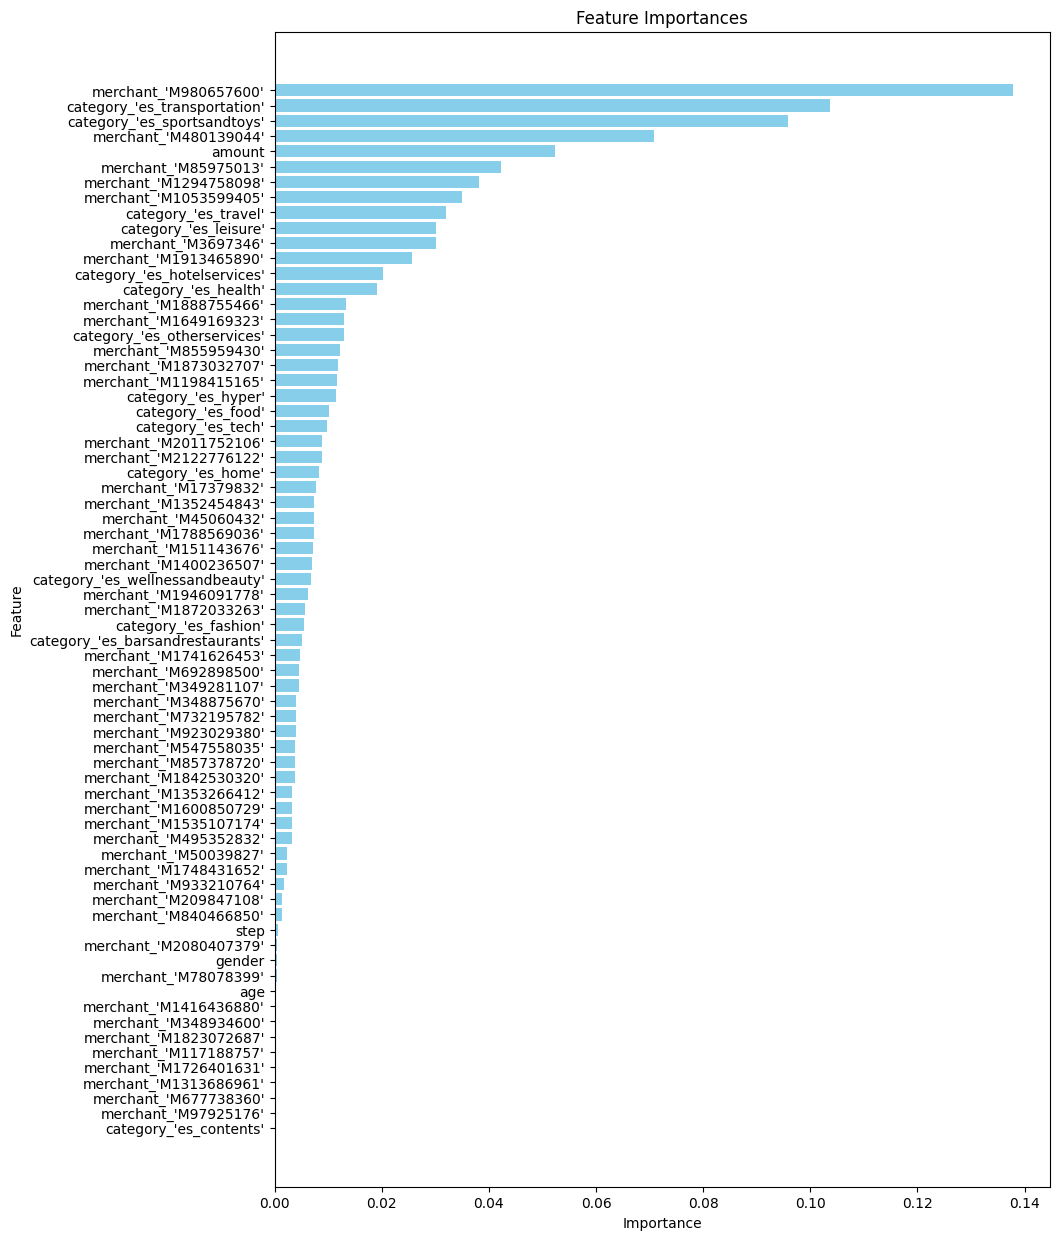

In [29]:
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 15))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

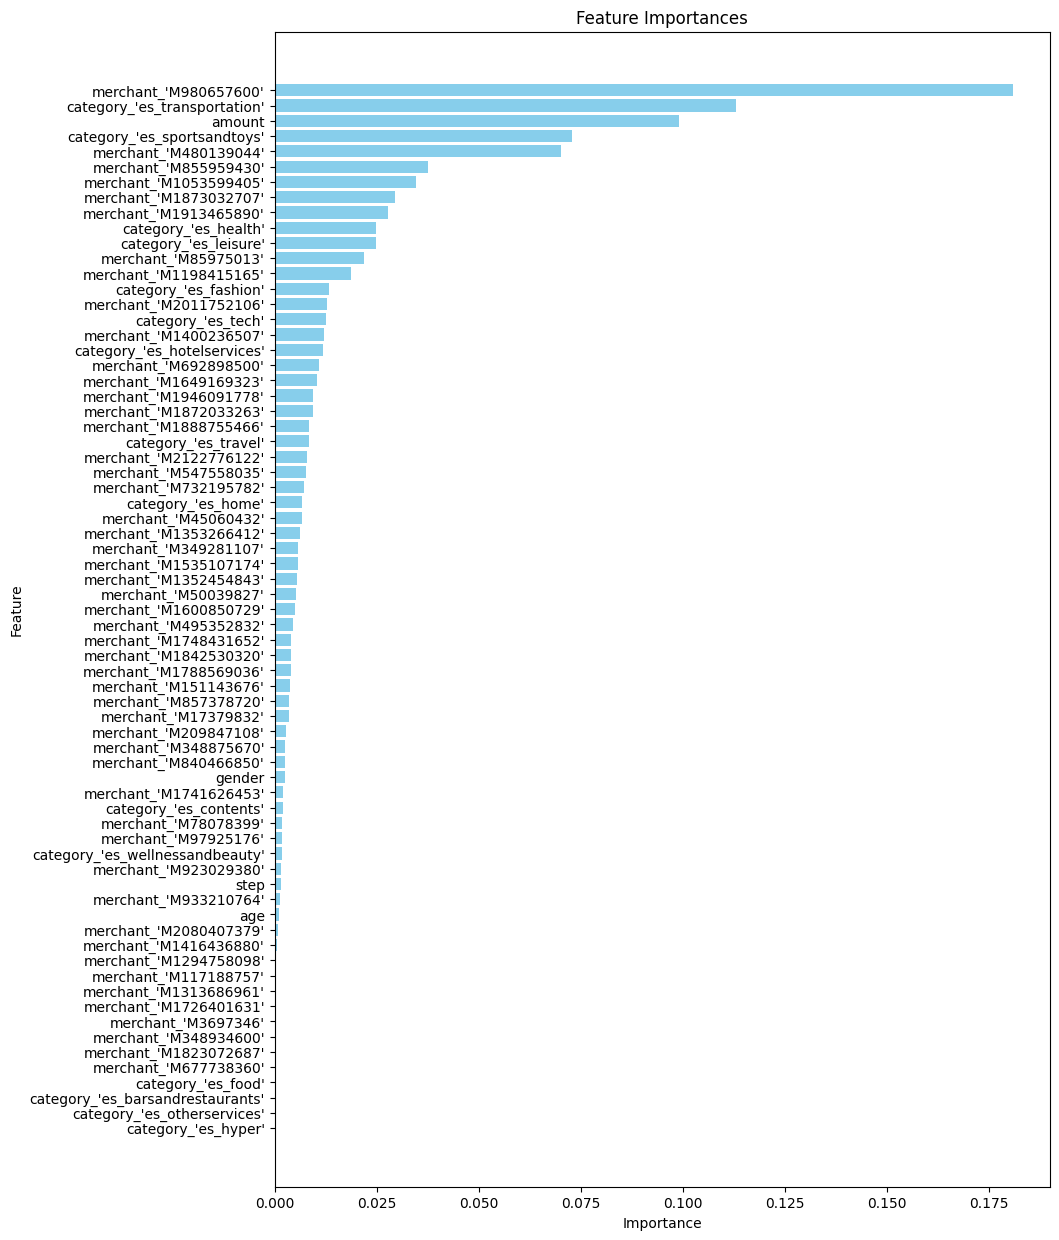

In [30]:
feature_importances = xgb_model_2.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 15))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [31]:
df[df['merchant'] == "'M980657600'"]['fraud'].value_counts(normalize=True) * 100

fraud
1    83.355263
0    16.644737
Name: proportion, dtype: float64

In [32]:
df[df['merchant'] == "'M980657600'"]['category'].value_counts(normalize=True) * 100

category
'es_sportsandtoys'    100.0
Name: proportion, dtype: float64

In [33]:
df[df['merchant'] == "'M480139044'"]['fraud'].value_counts(normalize=True) * 100

fraud
0    53.632761
1    46.367239
Name: proportion, dtype: float64

* It can be seen the highest feature importance was given to a merchant features under whom 83.3 % of transactions are fraudulent 
* The feature with second highest importance is the only category the merchant in first feature traded suggesting strong correlation 

----

# 5.Submission (Testing with test.csv file) 
#### Need to run the whole notebook with train and test csv files in the same dir 

In [34]:
from joblib import load 
from sklearn.metrics import roc_auc_score

def unit_test(csv_path = "train_hsbc_df.csv"):
    """
    Will print the accuracy , precission , recall , roc_auc given the test.csv path using the trained models 
    NOTE : Need the model weights of 2 xgb models
    =============================================
    """
    data = pd.read_csv(csv_path)
    df = data.copy() 
    #=================#
    ## data cleaning ## 
    #=================#
    data = data.drop("zipMerchant" , axis =1 )
    data = data.drop("zipcodeOri" , axis =1 )
    data = data.drop("customer" , axis =1 )

    #============================#
    ## data feature engineering ##
    #============================#
    ordinal_columns = ['age', 'gender']
    ordinal_encoder = OrdinalEncoder()
    data[ordinal_columns] = ordinal_encoder.fit_transform(data[ordinal_columns])      
    # One-hot encoding for 'merchant' and 'category'
    onehot_columns = ['merchant', 'category']
    onehot_encoder = OneHotEncoder(sparse_output=False)
    onehot_encoded = onehot_encoder.fit_transform(data[onehot_columns])
    # Get feature names for one-hot encoded columns
    feature_names = onehot_encoder.get_feature_names_out(onehot_columns)
    # Create a new DataFrame with one-hot encoded features
    onehot_data = pd.DataFrame(onehot_encoded, columns=feature_names)
    # Combine the original DataFrame with one-hot encoded features
    data_encoded = pd.concat([data.drop(columns=onehot_columns), onehot_data], axis=1)

    X_test , y_test = data_encoded.drop("fraud" , axis =1  )  , data_encoded["fraud"]

    #====================#
    ## Model Prediction ##
    #====================#
    model1 = load('xgb_model_1a.joblib')
    model2 = load('xgb_model_2a.joblib')
    y_pred_prob1 = model1.predict_proba(X_test)[:, 1]  # Probability of the positive class
    y_pred_prob2 = model2.predict_proba(X_test)[:, 1]  # Probability of the positive class

    # Combine the predictions using a weighted average
    weight1 = 0.6  # You can adjust these weights based on model performance
    weight2 = 0.4
    y_pred_prob_weighted = (weight1 * y_pred_prob1) + (weight2 * y_pred_prob2)

    # Convert weighted probabilities into final binary predictions
    threshold = 0.5
    y_pred_weighted = (y_pred_prob_weighted >= threshold).astype(int)
    df["prediction"] = y_pred_weighted
    df = df[["prediction"]]
    df.to_csv("results.csv",index=False)
    #====================#
    ## Model Evaluation ##
    #====================#
    print("Accuracy:", accuracy_score(y_test, y_pred_weighted))
    print("Classification Report:\n", classification_report(y_test, y_pred_weighted))
    roc_auc = roc_auc_score(y_test, y_pred_prob_weighted)
    print("ROC AUC Score:", roc_auc)

unit_test(csv_path="train_hsbc_df.csv")

Accuracy: 0.9960595199389459
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    507443
           1       0.93      0.73      0.82      6200

    accuracy                           1.00    513643
   macro avg       0.96      0.86      0.91    513643
weighted avg       1.00      1.00      1.00    513643

ROC AUC Score: 0.998066798921576


---